In [4]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import os
import seaborn as sns
from multiprocessing import Pool

In [ ]:
# NOTE: 
# Raw peptide data is not provided
# This serves only to document the OASis database filtering and extraction process

In [5]:
SOURCE_DATA = '../../data'
INPUT_DIR = '../../data/human/uniq/tree_of_9mers'
OUTPUT_DB = '../../data/human/uniq/oas_clean_human_subject_9mers_2019_11.db'
MIN_PERCENT_SUBJECTS = 1
MIN_SEQUENCES_PER_SUBJECT = 10000

In [6]:
!ls {INPUT_DIR}

AA  CF	DK  EP	FT  GY	IE  KI	LN  MS	NX  QD	RH  SM	TR  VW	XC  YG
AC  CG	DL  EQ	FV  HA	IF  KK	LP  MT	NY  QE	RI  SN	TS  VX	XD  YH
AD  CH	DM  ER	FW  HC	IG  KL	LQ  MV	PA  QF	RK  SP	TT  VY	XE  YI
AE  CI	DN  ES	FX  HD	IH  KM	LR  MW	PC  QG	RL  SQ	TV  WA	XF  YK
AF  CK	DP  ET	FY  HE	II  KN	LS  MX	PD  QH	RM  SR	TW  WC	XG  YL
AG  CL	DQ  EV	GA  HF	IK  KP	LT  MY	PE  QI	RN  SS	TX  WD	XH  YM
AH  CM	DR  EW	GC  HG	IL  KQ	LV  NA	PF  QK	RP  ST	TY  WE	XI  YN
AI  CN	DS  EX	GD  HH	IM  KR	LW  NC	PG  QL	RQ  SV	VA  WF	XK  YP
AK  CP	DT  EY	GE  HI	IN  KS	LX  ND	PH  QM	RR  SW	VC  WG	XL  YQ
AL  CQ	DV  FA	GF  HK	IP  KT	LY  NE	PI  QN	RS  SX	VD  WH	XM  YR
AM  CR	DW  FC	GG  HL	IQ  KV	MA  NF	PK  QP	RT  SY	VE  WI	XN  YS
AN  CS	DX  FD	GH  HM	IR  KW	MC  NG	PL  QQ	RV  TA	VF  WK	XP  YT
AP  CT	DY  FE	GI  HN	IS  KX	MD  NH	PM  QR	RW  TC	VG  WL	XQ  YV
AQ  CV	EA  FF	GK  HP	IT  KY	ME  NI	PN  QS	RX  TD	VH  WM	XR  YW
AR  CW	EC  FG	GL  HQ	IV  LA	MF  NK	PP  QT	RY  TE	VI  WN	XS  YX
AS  CX	ED  FH	GM  HR	IW  LC	MG  NL	PQ  QV	SA  TF	VK  WP

In [7]:
units = pd.read_csv(os.path.join(INPUT_DIR, 'units.tsv'), sep='\t')

units.set_index(units['Index'].str.replace('h','').astype(np.int), inplace=True)
units = units.drop(columns=['Index','Cdr3Records','NuclBytes','SeqBytes','Cdr3Bytes'])

units['Subject'] = units.apply('{0.StudyPath}:{0.Subject}'.format, axis=1)
units.head(3)

,UnitPath,StudyPath,Longitudinal,Chain,Author,Isotype,Age,Size_igblastn,Disease,Link,Vaccine,BType,Subject,Species,BSource,Size,Year,Processed,NuclRecords,SeqRecords
Index,,,,,,,,,,,,,,,,,,,,
1,Levin_2015_NoSIT_timepoint-365_tissue-PBMC_IGH...,Levin_2015,Day-365,Heavy,"Levin et al., (2015)",IGHD,24,1328,Allergy+NoSIT,http://dx.doi.org/10.1016/j.jaci.2015.09.027,None,Unsorted-B-Cells,Levin_2015:subject-12,human,PBMC,890,2015,NaN,1328,824
2,Levin_2015_NoSIT_timepoint-365_tissue-PBMC_IGH...,Levin_2015,Day-365,Heavy,"Levin et al., (2015)",IGHG,22,704,Allergy+NoSIT,http://dx.doi.org/10.1016/j.jaci.2015.09.027,None,Unsorted-B-Cells,Levin_2015:subject-14,human,PBMC,464,2015,NaN,704,421
3,Levin_2015_NoSIT_timepoint-365_tissue-PBMC_IGH...,Levin_2015,Day-365,Heavy,"Levin et al., (2015)",IGHA,38,1958,Allergy+NoSIT,http://dx.doi.org/10.1016/j.jaci.2015.09.027,None,Unsorted-B-Cells,Levin_2015:subject-13,human,PBMC,1306,2015,NaN,1958,1074


In [8]:
complete = []
for study in units['StudyPath'].unique():
    complete.append(pd.read_csv(f'../../data/all/stats/complete_seq_counts/{study}.tsv', sep='\t'))
complete = pd.concat(complete).set_index('UnitPath')['CompleteSeqs']
complete = complete.loc[units['UnitPath'].values]
complete.head()

UnitPath
Levin_2015_NoSIT_timepoint-365_tissue-PBMC_IGHD_NoSIT_tissue-PBMC_subject-12_timepoint-365_Age-24_SRR5755005_iglblastn_iglblastn_IGHD    0
Levin_2015_NoSIT_timepoint-365_tissue-PBMC_IGHG_NoSIT_tissue-PBMC_subject-14_timepoint-365_Age-22_SRR5755011_iglblastn_iglblastn_IGHG    0
Levin_2015_NoSIT_timepoint-365_tissue-PBMC_IGHA_NoSIT_tissue-PBMC_subject-13_timepoint-365_Age-38_SRR5755027_iglblastn_iglblastn_IGHA    0
Levin_2015_NoSIT_timepoint-0_tissue-Biopsy_IGHE_NoSIT_tissue-Biopsy_subject-11_timepoint-0_Age-23_SRR5755076_iglblastn_iglblastn_IGHE    0
Levin_2015_SIT_timepoint-0_tissue-PBMC_IGHG_SIT_tissue-PBMC_subject-8_timepoint-0_Age-24_SRR5755034_iglblastn_iglblastn_IGHG             0
Name: CompleteSeqs, dtype: int64

In [9]:
complete_seqs_per_subject = complete.groupby([units['Chain'].values, units['Subject'].values]).sum()
complete_seqs_per_subject

Heavy  Bashford_2013:subject-1          0
       Bashford_2013:subject-10         0
       Bashford_2013:subject-11         0
       Bashford_2013:subject-2          0
       Bashford_2013:subject-3          0
                                    ...  
Light  Zhou_2013:Donor-IAVI74      145715
       Zhou_2013:Donor-NIAID45      18454
       Zhou_2013:Donor-RU3         142562
       Zhu_2012:Donor-39            60172
       Zhu_2013:Donor-C38          333304
Name: CompleteSeqs, Length: 672, dtype: int64

In [10]:
def concat_unique(vals):
    return ', '.join(vals.fillna('None').value_counts(dropna=False).index)

def concat_age(vals):
    return '-'.join(sorted(vals.fillna('None').value_counts(dropna=False).index))

def combine_group(group):
    return group.apply({
        'Age': concat_age,
        'Disease': concat_unique,
        'Vaccine': concat_unique,
        'Isotype': concat_unique,
        'BType': concat_unique,
        'BSource': concat_unique,
        'Processed': concat_unique
    })


In [11]:
heavy_seqs_per_subject = units[units['Chain'] == 'Heavy'].groupby(['Subject'])['SeqRecords'].sum()
heavy_seqs_per_subject

Subject
Bashford_2013:subject-1       6441
Bashford_2013:subject-10     35495
Bashford_2013:subject-11         1
Bashford_2013:subject-2      11573
Bashford_2013:subject-3       7935
                             ...  
Zhou_2015:Donor-C38          49445
Zhou_2015:Donor-RU01         58674
Zhou_2015:Donor-RU08         93698
Zhu_2012:Donor-39           100368
Zhu_2013:Donor-C38          401552
Name: SeqRecords, Length: 503, dtype: int64

In [12]:
light_seqs_per_subject = units[units['Chain'] == 'Light'].groupby(['Subject'])['SeqRecords'].sum()
light_seqs_per_subject

Subject
Bernat_2019:A007           315778
Bhiman_2015:CAP256         114088
Doria-Rose_2015:CAP256     389774
Gidoni_2019:S1              99769
Gidoni_2019:S10            134816
                            ...  
Zhou_2013:Donor-IAVI74     155229
Zhou_2013:Donor-NIAID45     20143
Zhou_2013:Donor-RU3        157992
Zhu_2012:Donor-39           74389
Zhu_2013:Donor-C38         355157
Name: SeqRecords, Length: 169, dtype: int64

In [13]:
all_subjects = units.groupby(['Subject', 'StudyPath', 'Author', 'Link', 'Year']).apply(combine_group).reset_index()
assert len(all_subjects) == len(all_subjects[['StudyPath','Subject']].drop_duplicates())

removed = all_subjects[all_subjects['Subject'].str.endswith(':no')]['StudyPath'].unique()
print(f'Removed {len(removed)} studies with no subject annotation:')
print(" ".join(removed))
all_subjects = all_subjects[~all_subjects['Subject'].str.endswith(':no')]

all_subjects = all_subjects.replace('None', np.nan)
print(f'Total: {len(all_subjects)} subjects')

all_subjects.insert(1, 'HeavySeqs', heavy_seqs_per_subject.reindex(all_subjects['Subject'], fill_value=0).values)
all_subjects.insert(2, 'LightSeqs', light_seqs_per_subject.reindex(all_subjects['Subject'], fill_value=0).values)

all_subjects.insert(3, 'CompleteHeavySeqs', complete_seqs_per_subject.loc['Heavy'].reindex(all_subjects['Subject'], fill_value=0).values)
all_subjects.insert(4, 'CompleteLightSeqs', complete_seqs_per_subject.loc['Light'].reindex(all_subjects['Subject'], fill_value=0).values)

Removed 8 studies with no subject annotation:
Halliley_2015 Jiang_2013 Joyce_2016 Liao_2013 Mroczek_2014 Schanz_2014 Sheng_2017 Vergani_2017
Total: 500 subjects


In [14]:
subjects = all_subjects.copy()

removed = subjects[(subjects['CompleteHeavySeqs'] < MIN_SEQUENCES_PER_SUBJECT) & (subjects['CompleteLightSeqs'] < MIN_SEQUENCES_PER_SUBJECT)]['Subject'].unique()
print(f'Removed {len(removed)} subjects with less than {MIN_SEQUENCES_PER_SUBJECT:,} sequences in heavy and light chain')
print(" ".join(sorted(set(r.split(':')[0] for r in removed))))
subjects = subjects[~subjects['Subject'].isin(removed)]

print(f'Final: {len(subjects)} subjects')

assert subjects['Subject'].is_unique

subjects['Index'] = [i for i in range(1, len(subjects)+1)]
subjects.set_index('Index', verify_integrity=True, inplace=True)

subjects.head()

Removed 269 subjects with less than 10,000 sequences in heavy and light chain
Bashford_2013 Briney_2019 Davis_2019 Eliyahu_2018 Ellebedy_2016 Galson_2015 Galson_2015a Galson_2016 Galson_2016a Ghraichy_2019 Gidoni_2019 Levin_2015 Levin_2017 Meng_2017a Ohm-Laursen_2018 Parameswaran_2014 Setliff_2018a Stern_2014 Thornqvist_2018 Turchaninova_2016 Waltari_2018 Wu_2014
Final: 231 subjects


,Subject,HeavySeqs,LightSeqs,CompleteHeavySeqs,CompleteLightSeqs,StudyPath,Author,Link,Year,Age,Disease,Vaccine,Isotype,BType,BSource,Processed
Index,,,,,,,,,,,,,,,,
1,Bernat_2019:A007,423912,315778,390689,303913,Bernat_2019,"Bernat et al., (2019)",https://www.frontiersin.org/articles/10.3389/f...,2019,no,NaN,NaN,"Bulk, IGHM, IGHG, IGHA",Unsorted-B-Cells,PBMC,no
2,Bhiman_2015:CAP256,73793,114088,64256,108444,Bhiman_2015,"Bhiman et al., (2015)",https://www.ncbi.nlm.nih.gov/pubmed/26457756,2015,no,HIV,NaN,"Bulk, IGHG, IGHA, IGHM, IGHE",Unsorted-B-Cells,PBMC,NaN
3,Bonsignori_2016:CH505,58841,0,20507,0,Bonsignori_2016,"Bonsignori et al., (2016)",https://doi.org/10.1016/j.cell.2016.02.022,2016,no,"HIV, None",NaN,"Bulk, IGHE, IGHG, IGHD, IGHM","Unsorted-B-Cells, Memory-B-Cells",PBMC,NaN
4,Corcoran_2016:H1,457247,0,447879,0,Corcoran_2016,"Corcoran et al., (2016)",https://dx.doi.org/10.1038/ncomms13642,2016,no,NaN,NaN,"Bulk, IGHG, IGHA, IGHD, IGHM, IGHE",Unsorted-B-Cells,PBMC,NaN
5,Doria-Rose_2015:CAP256,168151,389774,117664,371998,Doria-Rose_2015,"Doria-Rose et al., (2015)",https://www.nature.com/articles/nature13036,2015,no,HIV,NaN,"Bulk, IGHG, IGHM, IGHE, IGHA, IGHD",Unsorted-B-Cells,PBMC,NaN


In [15]:
heavy_subjects = subjects[subjects['CompleteHeavySeqs'] >= MIN_SEQUENCES_PER_SUBJECT]
len(heavy_subjects)

225

In [16]:
light_subjects = subjects[subjects['CompleteLightSeqs'] >= MIN_SEQUENCES_PER_SUBJECT]
len(light_subjects)

154

In [34]:
selected_heavy_idx = frozenset(heavy_subjects.index)
selected_light_idx = frozenset(light_subjects.index)

In [17]:
min_heavy_subjects = int(np.floor(len(heavy_subjects) * MIN_PERCENT_SUBJECTS / 100))
min_heavy_subjects

2

In [18]:
min_light_subjects = int(np.floor(len(light_subjects) * MIN_PERCENT_SUBJECTS / 100))
min_light_subjects

1

In [19]:
subject_name_to_index = subjects.reset_index().set_index('Subject')['Index']

In [20]:
unit_idx_to_subject_idx = pd.Series(subject_name_to_index.reindex(units['Subject'], fill_value=0).values, units.index).to_dict()

# Save subjects

In [97]:
print(OUTPUT_DB)
if os.path.exists(OUTPUT_DB) and input('Confirm delete y/n:').lower() == 'y':
    os.remove(OUTPUT_DB)
    print('Deleted', OUTPUT_DB)

../../data/human/uniq/oas_clean_human_subject_9mers_2019_11.db


In [98]:
engine = create_engine('sqlite:///'+OUTPUT_DB, echo=False)

In [106]:
%%time

subjects.to_sql('subjects', con=engine, index_label='id', if_exists='replace')

CPU times: user 30.4 ms, sys: 13.1 ms, total: 43.5 ms
Wall time: 338 ms


In [107]:
%%time

engine.execute("CREATE INDEX ix_subjects_hc ON subjects (HeavySeqs);")
engine.execute("CREATE INDEX ix_subjects_lc ON subjects (LightSeqs);")
engine.execute("CREATE INDEX ix_subjects_chc ON subjects (CompleteHeavySeqs);")
engine.execute("CREATE INDEX ix_subjects_clc ON subjects (CompleteLightSeqs);")

CPU times: user 3.19 ms, sys: 14.6 ms, total: 17.8 ms
Wall time: 454 ms


In [108]:
engine.execute("SELECT * FROM subjects").fetchall()[:3]

[(1, 'Bernat_2019:A007', 423912, 315778, 390689, 303913, 'Bernat_2019', 'Bernat et al., (2019)', 'https://www.frontiersin.org/articles/10.3389/fimmu.2019.00660/full', 2019, 'no', None, None, 'Bulk, IGHM, IGHA, IGHG', 'Unsorted-B-Cells', 'PBMC', 'no'),
 (2, 'Bhiman_2015:CAP256', 73793, 114088, 64256, 108444, 'Bhiman_2015', 'Bhiman et al., (2015)', 'https://www.ncbi.nlm.nih.gov/pubmed/26457756', 2015, 'no', 'HIV', None, 'Bulk, IGHA, IGHE, IGHG, IGHM', 'Unsorted-B-Cells', 'PBMC', None),
 (3, 'Bonsignori_2016:CH505', 58841, 0, 20507, 0, 'Bonsignori_2016', 'Bonsignori et al., (2016)', 'https://doi.org/10.1016/j.cell.2016.02.022', 2016, 'no', 'HIV, None', None, 'Bulk, IGHE, IGHG, IGHD, IGHM', 'Unsorted-B-Cells, Memory-B-Cells', 'PBMC', None)]

In [109]:
engine.execute("PRAGMA index_list(subjects);").fetchall()

[(0, 'ix_subjects_clc', 0, 'c', 0),
 (1, 'ix_subjects_chc', 0, 'c', 0),
 (2, 'ix_subjects_lc', 0, 'c', 0),
 (3, 'ix_subjects_hc', 0, 'c', 0),
 (4, 'ix_subjects_id', 0, 'c', 0)]

In [110]:
ls -lh {OUTPUT_DB}

-rw-r--r-- 1 prihodad molsys 76K Jan 24 17:07 ../../data/human/uniq/oas_clean_human_subject_9mers_2019_11.db


# Save peptides

In [21]:
paths = []
for dirpath in os.listdir(INPUT_DIR):
    dirpath = os.path.join(INPUT_DIR, dirpath) 
    if not os.path.isdir(dirpath):
        print('Skipping', dirpath)
        continue
    for filepath in os.listdir(dirpath):
        paths.append(os.path.join(dirpath, filepath) )
len(paths)

Skipping ../../data/human/uniq/tree_of_9mers/units.tsv


9868

In [22]:
def iterate_files(paths):
    for path in paths:
        with open(path) as f:
            yield f.readlines()

In [23]:
heavy_unit_ids = frozenset(units.index[units['Chain'] == 'Heavy'])
len(heavy_unit_ids)

6040

In [24]:
light_unit_ids = frozenset(units.index[units['Chain'] == 'Light'])
len(light_unit_ids)

273

In [115]:
%%time

engine.execute("DROP TABLE IF EXISTS peptides;")

saved_rows = 0
saved_peptides = 0
for i, lines in enumerate(iterate_files(paths)):
    if i % 100 == 0:
        print(f'Saved {i:,}/{len(paths):,} files ({saved_rows:,} rows, {saved_peptides:,} unique peptides)')
    chunk = []
    for line in lines:
        peptide, count_str = line.strip().split('\t')
        assert len(peptide) == 9
        count_dict = {}
        for kv in count_str.split(','):
            unit_idx = int(kv.split(':')[0].replace('h',''))
            if unit_idx in heavy_unit_ids:
                is_light = False
            elif unit_idx in light_unit_ids:
                is_light = True
            else:
                raise ValueError(unit_idx)
            subject_idx = unit_idx_to_subject_idx[unit_idx]
            if subject_idx == 0:
                # Skip removed subjects
                continue
            count = int(kv.split(':')[1])
            count_dict[subject_idx] = count_dict.get(subject_idx, 0) + count
        min_subjects = min_light_subjects if is_light else min_heavy_subjects
        if len(count_dict) < min_subjects:
            continue
        saved_peptides += 1
        chunk += [[peptide, subj, count] for subj, count in count_dict.items()]
    chunk = pd.DataFrame(chunk, columns=['peptide','subject','count'])
    chunk.to_sql('peptides', index=False, con=engine, if_exists='append')
    saved_rows += len(chunk)

print('')
print(f'Saved {saved_rows:,} peptide-subject count pairs for {saved_peptides:,} unique peptides')
print('')

Saved 0/9,868 files (0 rows, 0 unique peptides)
Saved 100/9,868 files (4,081,589 rows, 1,060,332 unique peptides)
Saved 200/9,868 files (6,706,438 rows, 1,732,191 unique peptides)
Saved 300/9,868 files (9,904,969 rows, 2,716,567 unique peptides)
Saved 400/9,868 files (14,049,200 rows, 3,891,711 unique peptides)
Saved 500/9,868 files (21,873,828 rows, 5,998,087 unique peptides)
Saved 600/9,868 files (31,663,868 rows, 8,457,751 unique peptides)
Saved 700/9,868 files (40,798,763 rows, 10,763,188 unique peptides)
Saved 800/9,868 files (43,340,330 rows, 11,412,587 unique peptides)
Saved 900/9,868 files (45,080,953 rows, 11,904,845 unique peptides)
Saved 1,000/9,868 files (46,907,508 rows, 12,560,403 unique peptides)
Saved 1,100/9,868 files (50,322,535 rows, 13,456,053 unique peptides)
Saved 1,200/9,868 files (60,113,838 rows, 15,824,502 unique peptides)
Saved 1,300/9,868 files (65,363,402 rows, 17,058,426 unique peptides)
Saved 1,400/9,868 files (77,228,303 rows, 19,723,236 unique peptides)

In [116]:
chunk.tail()

,peptide,subject,count
42777,VDAIRSGWV,125,1
42778,VDAATTPAH,148,2
42779,VDAATTPAH,146,1
42780,VDASKNRCA,152,1
42781,VDASKNRCA,154,1


In [117]:
engine.execute("PRAGMA index_list(peptides);").fetchall()

[]

In [118]:
!ls -lh {OUTPUT_DB}

-rw-r--r-- 1 prihodad molsys 12G Jan 24 19:28 ../../data/human/uniq/oas_clean_human_subject_9mers_2019_11.db


In [119]:
%%time

engine.execute("CREATE INDEX ix_peptides_peptide ON peptides (peptide);")

CPU times: user 4min 55s, sys: 39.3 s, total: 5min 34s
Wall time: 5min 41s


In [120]:
engine.execute("PRAGMA index_list(peptides);").fetchall()

[(0, 'ix_peptides_peptide', 0, 'c', 0)]

In [121]:
!ls -lh {OUTPUT_DB}

-rw-r--r-- 1 prihodad molsys 22G Jan 24 19:34 ../../data/human/uniq/oas_clean_human_subject_9mers_2019_11.db


In [122]:
engine.execute("SELECT * FROM peptides LIMIT 10").fetchall()[:3]

[('FGHWGRGTL', 216, 3), ('FGHWGRGTL', 198, 2), ('FGHWGRGTL', 196, 1)]

In [123]:
engine.execute("EXPLAIN QUERY PLAN SELECT * FROM peptides WHERE peptide = 'FGGNTQSNP'").fetchall()

[(3, 0, 0, 'SEARCH TABLE peptides USING INDEX ix_peptides_peptide (peptide=?)')]

In [124]:
%%timeit

engine.execute("SELECT * FROM peptides WHERE peptide = 'FGGNTQSNP'").fetchall()

64.3 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [125]:
engine.execute("EXPLAIN QUERY PLAN SELECT * FROM peptides LEFT JOIN subjects ON peptides.subject = subjects.id WHERE peptide = 'FGGNTQSNP'").fetchall()

[(5, 0, 0, 'SEARCH TABLE peptides USING INDEX ix_peptides_peptide (peptide=?)'),
 (10, 0, 0, 'SEARCH TABLE subjects USING INDEX ix_subjects_id (id=?)')]

In [126]:
%%timeit

engine.execute("SELECT * FROM peptides LEFT JOIN subjects ON peptides.subject = subjects.id WHERE peptide = 'FGGNTQSNP'").fetchall()

65.1 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [127]:
len(engine.execute(f"SELECT * FROM subjects WHERE CompleteHeavySeqs >= {MIN_SEQUENCES_PER_SUBJECT}").fetchall())

225

In [135]:
end = engine.execute(f"SELECT * FROM peptides LEFT JOIN subjects ON peptides.subject = subjects.id WHERE peptide = 'QGTLVTVSS' AND CompleteHeavySeqs >= {MIN_SEQUENCES_PER_SUBJECT}").fetchall()
len(end)

225

In [137]:
beginning = engine.execute(f"SELECT * FROM peptides LEFT JOIN subjects ON peptides.subject = subjects.id WHERE peptide = 'QVQLVESGG' AND CompleteHeavySeqs >= {MIN_SEQUENCES_PER_SUBJECT}").fetchall()
len(beginning)

220

In [130]:
!gzip -c {OUTPUT_DB} > {OUTPUT_DB}.gz

In [131]:
!ls -lh {OUTPUT_DB}.gz

-rw-r--r-- 1 prihodad molsys 6.1G Jan 24 19:53 ../../data/human/uniq/oas_clean_human_subject_9mers_2019_11.db.gz


In [132]:
!time gunzip -c {OUTPUT_DB}.gz > /dev/null


real	2m11.832s
user	2m10.115s
sys	0m1.380s


# Subject peptide overlap

In [25]:
num_subjects = len(subjects)
num_subjects

231

In [26]:
dirs = []
for dirpath in os.listdir(INPUT_DIR):
    dirpath = os.path.join(INPUT_DIR, dirpath) 
    if not os.path.isdir(dirpath):
        print('Skipping', dirpath)
        continue
    dirs.append(dirpath)
len(dirs), dirs[0]

Skipping ../../data/human/uniq/tree_of_9mers/units.tsv


(441, '../../data/human/uniq/tree_of_9mers/FG')

In [27]:
def collect_overlap(dirpath, weight_by_num_subjects=False):
    paths = []
    for filepath in os.listdir(dirpath):
        paths.append(os.path.join(dirpath, filepath))
        
    heavy_overlap = pd.DataFrame(np.zeros(shape=(num_subjects, num_subjects)), index=subjects['Subject'], columns=subjects['Subject'], dtype='int64')
    light_overlap = pd.DataFrame(np.zeros(shape=(num_subjects, num_subjects)), index=subjects['Subject'], columns=subjects['Subject'], dtype='int64')

    for i, lines in enumerate(iterate_files(paths)):
        for line in lines:
            peptide, count_str = line.strip().split('\t')
            assert len(peptide) == 9
            heavy_subjects_idx = set()
            light_subjects_idx = set()
            counts = []
            for kv in count_str.split(','):
                unit_idx = int(kv.split(':')[0].replace('h',''))
                subject_idx = unit_idx_to_subject_idx[unit_idx]
                if subject_idx == 0:
                    # Skip removed subjects
                    continue
                counts.append(int(kv.split(':')[1]))
                if unit_idx in heavy_unit_ids:
                    if subject_idx in selected_heavy_idx:
                        heavy_subjects_idx.add(subject_idx-1)
                elif unit_idx in light_unit_ids:
                    if subject_idx in selected_light_idx:
                        light_subjects_idx.add(subject_idx-1)
                else:
                    raise ValueError(unit_idx)
            if heavy_subjects_idx:
                heavy_subjects_idx = list(heavy_subjects_idx)
                heavy_overlap.iloc[heavy_subjects_idx,heavy_subjects_idx] += len(heavy_subjects_idx) if weight_by_num_subjects else 1
            if light_subjects_idx:
                light_subjects_idx = list(light_subjects_idx)
                light_overlap.iloc[light_subjects_idx,light_subjects_idx] += len(light_subjects_idx) if weight_by_num_subjects else 1
    
    return heavy_overlap, light_overlap

In [43]:
%%time

pool = Pool(28)
overlap = pool.map(collect_overlap, dirs)

CPU times: user 1min 45s, sys: 1min 51s, total: 3min 36s
Wall time: 7h 21min 3s


In [44]:
heavy_intersection = sum([h for h, l in overlap])
heavy_intersection = heavy_intersection.loc[heavy_subjects['Subject'], heavy_subjects['Subject']]
heavy_intersection.head()

Subject,Bernat_2019:A007,Bhiman_2015:CAP256,Bonsignori_2016:CH505,Corcoran_2016:H1,Doria-Rose_2015:CAP256,Eliyahu_2018:C10,Eliyahu_2018:C4,Eliyahu_2018:C6,Eliyahu_2018:C7,Eliyahu_2018:C9,...,Waltari_2018:MT1214,Waltari_2018:MT8004,Wu_2011:Donor-74,Wu_2015:Donor-45,Zhou_2015:Donor-44,Zhou_2015:Donor-C38,Zhou_2015:Donor-RU01,Zhou_2015:Donor-RU08,Zhu_2012:Donor-39,Zhu_2013:Donor-C38
Subject,,,,,,,,,,,,,,,,,,,,,
Bernat_2019:A007,2696574,108092,206420,453190,294323,111755,102918,85077,118312,107450,...,641436,643234,128528,309793,126806,115932,105357,97800,138489,335629
Bhiman_2015:CAP256,108092,362985,76616,96976,125178,41593,38984,33173,45751,40856,...,130028,133988,32069,65584,34091,71723,29012,27223,48195,93964
Bonsignori_2016:CH505,206420,76616,911389,206008,208098,91451,83918,67807,91909,85983,...,290036,307455,91142,191089,82061,81906,71288,67461,111979,221192
Corcoran_2016:H1,453190,96976,206008,3141354,284506,113429,103989,85298,121874,107220,...,680564,672337,148136,366849,155774,102666,120296,118880,138638,380806
Doria-Rose_2015:CAP256,294323,125178,208098,284506,1586970,109408,95428,77838,108929,101524,...,453761,475452,131066,284529,116465,114555,92802,93523,149860,318520


In [45]:
light_intersection = sum([l for h, l in overlap])
light_intersection = light_intersection.loc[light_subjects['Subject'], light_subjects['Subject']]
light_intersection.head()

Subject,Bernat_2019:A007,Bhiman_2015:CAP256,Doria-Rose_2015:CAP256,Gidoni_2019:S1,Gidoni_2019:S10,Gidoni_2019:S100,Gidoni_2019:S11,Gidoni_2019:S12,Gidoni_2019:S13,Gidoni_2019:S14,...,Waltari_2018:MT8004,Wu_2011:Donor-45,Wu_2015:Donor-45,Zhou_2013:Donor-IAVI23,Zhou_2013:Donor-IAVI57,Zhou_2013:Donor-IAVI74,Zhou_2013:Donor-NIAID45,Zhou_2013:Donor-RU3,Zhu_2012:Donor-39,Zhu_2013:Donor-C38
Subject,,,,,,,,,,,,,,,,,,,,,
Bernat_2019:A007,1426135,91375,329956,155478,232889,202466,199545,218150,221199,181612,...,681058,41864,196274,112177,88445,169467,55603,132640,83845,300384
Bhiman_2015:CAP256,91375,235310,148691,43006,53667,42356,44087,47512,47539,37679,...,144816,1133,4968,21256,2571,49077,1328,3347,2093,96738
Doria-Rose_2015:CAP256,329956,148691,1373970,135175,179017,147048,149569,164340,163029,130762,...,655792,46063,214817,121892,93911,196279,60349,145224,93163,382503
Gidoni_2019:S1,155478,43006,135175,305922,149365,134252,137473,144565,145446,122806,...,237436,24593,81447,60991,44996,88342,35303,65671,43882,129581
Gidoni_2019:S10,232889,53667,179017,149365,585482,201178,203162,216527,221737,185538,...,389957,27642,111739,75830,55757,108063,39665,82252,52402,168609


In [46]:
heavy_size = heavy_intersection.values[np.eye(*heavy_intersection.shape, dtype='bool')]
light_size = light_intersection.values[np.eye(*light_intersection.shape, dtype='bool')]

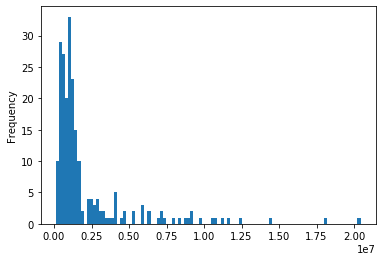

In [47]:
pd.Series(heavy_size).plot.hist(bins=100);

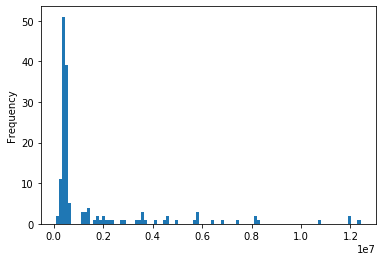

In [48]:
pd.Series(light_size).plot.hist(bins=100);

In [28]:
def collect_weighted_overlap(dirname):
    return collect_overlap(dirname, weight_by_num_subjects=True)

In [35]:
%%time

pool = Pool(28)
weighted_overlap = pool.map(collect_weighted_overlap, dirs)

CPU times: user 1min 4s, sys: 51.1 s, total: 1min 55s
Wall time: 7h 22min 30s


In [36]:
heavy_weighted_intersection = sum([h for h, l in weighted_overlap])
heavy_weighted_intersection = heavy_weighted_intersection.loc[heavy_subjects['Subject'], heavy_subjects['Subject']]
heavy_weighted_intersection.head()

Subject,Bernat_2019:A007,Bhiman_2015:CAP256,Bonsignori_2016:CH505,Corcoran_2016:H1,Doria-Rose_2015:CAP256,Eliyahu_2018:C10,Eliyahu_2018:C4,Eliyahu_2018:C6,Eliyahu_2018:C7,Eliyahu_2018:C9,...,Waltari_2018:MT1214,Waltari_2018:MT8004,Wu_2011:Donor-74,Wu_2015:Donor-45,Zhou_2015:Donor-44,Zhou_2015:Donor-C38,Zhou_2015:Donor-RU01,Zhou_2015:Donor-RU08,Zhu_2012:Donor-39,Zhu_2013:Donor-C38
Subject,,,,,,,,,,,,,,,,,,,,,
Bernat_2019:A007,66300650,12777520,23305048,42113191,29983823,14720213,13994271,11966203,15941580,14438378,...,51599801,51676748,14319334,25621890,13076338,12897670,11351021,10989488,16124703,31022076
Bhiman_2015:CAP256,12777520,16260667,9889732,12062317,12561529,6261851,6028514,5306238,6981633,6276809,...,13880284,14092598,4453000,7222467,4442806,9133800,4020692,3905266,6874690,11082014
Bonsignori_2016:CH505,23305048,9889732,33568274,23641648,22297904,12429267,11837432,10016129,13028812,12041496,...,27644781,28368082,10789855,17846934,9373428,10009490,8491378,8265100,13449788,22594276
Corcoran_2016:H1,42113191,12062317,23641648,72622482,29996524,15047576,14200213,12052787,16304232,14536574,...,54937951,54894418,15925152,28914896,15018078,12144450,12524194,12569365,16344218,33619905
Doria-Rose_2015:CAP256,29983823,12561529,22297904,29996524,46901571,13888672,12782604,10885752,14578533,13327863,...,37587675,38452211,13897522,23430054,12172794,12369382,10440490,10492744,16121136,29208870


In [37]:
light_weighted_intersection = sum([l for h, l in weighted_overlap])
light_weighted_intersection = light_weighted_intersection.loc[light_subjects['Subject'], light_subjects['Subject']]
light_weighted_intersection.head()

Subject,Bernat_2019:A007,Bhiman_2015:CAP256,Doria-Rose_2015:CAP256,Gidoni_2019:S1,Gidoni_2019:S10,Gidoni_2019:S100,Gidoni_2019:S11,Gidoni_2019:S12,Gidoni_2019:S13,Gidoni_2019:S14,...,Waltari_2018:MT8004,Wu_2011:Donor-45,Wu_2015:Donor-45,Zhou_2013:Donor-IAVI23,Zhou_2013:Donor-IAVI57,Zhou_2013:Donor-IAVI74,Zhou_2013:Donor-NIAID45,Zhou_2013:Donor-RU3,Zhu_2012:Donor-39,Zhu_2013:Donor-C38
Subject,,,,,,,,,,,,,,,,,,,,,
Bernat_2019:A007,42691679,7242450,23204471,16870151,23005802,20979382,20839822,22160048,22344817,19342596,...,37779417,4116798,13660345,9907602,7633091,14762562,5571880,10954349,7417689,22000199
Bhiman_2015:CAP256,7242450,9198146,8255763,4815003,5798784,4965468,5134991,5400936,5419354,4585002,...,8685175,138973,467575,2073317,271401,4357175,162476,353510,233509,7018340
Doria-Rose_2015:CAP256,23204471,8255763,35347486,14444815,17971876,15956305,16174114,17194951,17159809,14677781,...,31598912,4192462,12926596,9706881,7408066,15148423,5607001,10773799,7470222,23194048
Gidoni_2019:S1,16870151,4815003,14444815,22583242,17228402,15987663,16238365,16844987,16929607,14927959,...,21539826,3090936,8313926,7059724,5238675,10350406,4340021,7375362,5197971,13972273
Gidoni_2019:S10,23005802,5798784,17971876,17228402,34149030,21894172,22015566,23060404,23432880,20460049,...,31378504,3392808,10720432,8304837,6218982,12096624,4774926,8793040,5964654,17252425


In [38]:
heavy_weighted_size = pd.Series(heavy_weighted_intersection.values[np.eye(*heavy_weighted_intersection.shape, dtype='bool')], heavy_weighted_intersection.index)
light_weighted_size = pd.Series(light_weighted_intersection.values[np.eye(*light_weighted_intersection.shape, dtype='bool')], light_weighted_intersection.index)
heavy_weighted_union = (((-heavy_weighted_intersection) + heavy_weighted_size).T + heavy_weighted_size).T
light_weighted_union = (((-light_weighted_intersection) + light_weighted_size).T + light_weighted_size).T
heavy_weighted_similarity = heavy_weighted_intersection / heavy_weighted_union
light_weighted_similarity = light_weighted_intersection / light_weighted_union

In [39]:
heavy_weighted_similarity.head()

Subject,Bernat_2019:A007,Bhiman_2015:CAP256,Bonsignori_2016:CH505,Corcoran_2016:H1,Doria-Rose_2015:CAP256,Eliyahu_2018:C10,Eliyahu_2018:C4,Eliyahu_2018:C6,Eliyahu_2018:C7,Eliyahu_2018:C9,...,Waltari_2018:MT1214,Waltari_2018:MT8004,Wu_2011:Donor-74,Wu_2015:Donor-45,Zhou_2015:Donor-44,Zhou_2015:Donor-C38,Zhou_2015:Donor-RU01,Zhou_2015:Donor-RU08,Zhu_2012:Donor-39,Zhu_2013:Donor-C38
Subject,,,,,,,,,,,,,,,,,,,,,
Bernat_2019:A007,1.000000,0.183102,0.304387,0.435009,0.360303,0.207641,0.199775,0.173271,0.225098,0.205485,...,0.348491,0.351394,0.190245,0.266917,0.172746,0.183153,0.155316,0.150309,0.220016,0.334460
Bhiman_2015:CAP256,0.183102,1.000000,0.247620,0.157019,0.248248,0.213636,0.215490,0.206625,0.234751,0.221120,...,0.102252,0.104695,0.126887,0.112235,0.129565,0.378305,0.132374,0.129499,0.211536,0.176880
Bonsignori_2016:CH505,0.304387,0.247620,1.000000,0.286395,0.383310,0.307266,0.299875,0.261666,0.317768,0.301570,...,0.198470,0.206106,0.234232,0.251243,0.200857,0.246685,0.196511,0.191745,0.311112,0.330094
Corcoran_2016:H1,0.435009,0.157019,0.286395,1.000000,0.335054,0.195710,0.186438,0.160072,0.212350,0.190049,...,0.363707,0.365557,0.199105,0.292008,0.187546,0.156712,0.160090,0.161447,0.205869,0.348477
Doria-Rose_2015:CAP256,0.360303,0.248248,0.383310,0.335054,1.000000,0.265431,0.246470,0.214532,0.276189,0.256422,...,0.263441,0.272928,0.246889,0.297393,0.212807,0.239952,0.191236,0.193556,0.299130,0.388588


In [40]:
light_weighted_similarity.head()

Subject,Bernat_2019:A007,Bhiman_2015:CAP256,Doria-Rose_2015:CAP256,Gidoni_2019:S1,Gidoni_2019:S10,Gidoni_2019:S100,Gidoni_2019:S11,Gidoni_2019:S12,Gidoni_2019:S13,Gidoni_2019:S14,...,Waltari_2018:MT8004,Wu_2011:Donor-45,Wu_2015:Donor-45,Zhou_2013:Donor-IAVI23,Zhou_2013:Donor-IAVI57,Zhou_2013:Donor-IAVI74,Zhou_2013:Donor-NIAID45,Zhou_2013:Donor-RU3,Zhu_2012:Donor-39,Zhu_2013:Donor-C38
Subject,,,,,,,,,,,,,,,,,,,,,
Bernat_2019:A007,1.000000,0.162214,0.423171,0.348522,0.427340,0.402315,0.399830,0.417654,0.415886,0.376688,...,0.338772,0.094570,0.257934,0.216369,0.167994,0.314414,0.126715,0.232004,0.164529,0.408221
Bhiman_2015:CAP256,0.162214,1.000000,0.227495,0.178556,0.154435,0.143233,0.149564,0.148688,0.145838,0.140587,...,0.081079,0.009915,0.014316,0.102991,0.014059,0.182579,0.010227,0.014534,0.012437,0.198363
Doria-Rose_2015:CAP256,0.423171,0.227495,1.000000,0.332172,0.348802,0.320244,0.327125,0.339289,0.332754,0.301579,...,0.286339,0.116097,0.278889,0.251169,0.193333,0.386216,0.153229,0.268991,0.198214,0.511391
Gidoni_2019:S1,0.348522,0.178556,0.332172,1.000000,0.436119,0.431750,0.443492,0.440219,0.433703,0.418674,...,0.200092,0.126424,0.217650,0.247452,0.188967,0.331145,0.172944,0.240343,0.191132,0.334166
Gidoni_2019:S10,0.427340,0.154435,0.348802,0.436119,1.000000,0.512874,0.519194,0.528721,0.531388,0.490778,...,0.286884,0.095002,0.226370,0.213765,0.162341,0.294494,0.131810,0.215331,0.156986,0.344373


In [49]:
subjects_with_stats = subjects.copy()
subjects_with_stats.insert(1, 'HeavyPeptides', pd.Series(heavy_size, heavy_intersection.index).reindex(subjects['Subject'], fill_value=0).values)
subjects_with_stats.insert(2, 'LightPeptides', pd.Series(light_size, light_intersection.index).reindex(subjects['Subject'], fill_value=0).values)
subjects_with_stats.head()

,Subject,HeavyPeptides,LightPeptides,HeavySeqs,LightSeqs,CompleteHeavySeqs,CompleteLightSeqs,StudyPath,Author,Link,Year,Age,Disease,Vaccine,Isotype,BType,BSource,Processed
Index,,,,,,,,,,,,,,,,,,
1,Bernat_2019:A007,2696574,1426135,423912,315778,390689,303913,Bernat_2019,"Bernat et al., (2019)",https://www.frontiersin.org/articles/10.3389/f...,2019,no,NaN,NaN,"Bulk, IGHM, IGHG, IGHA",Unsorted-B-Cells,PBMC,no
2,Bhiman_2015:CAP256,362985,235310,73793,114088,64256,108444,Bhiman_2015,"Bhiman et al., (2015)",https://www.ncbi.nlm.nih.gov/pubmed/26457756,2015,no,HIV,NaN,"Bulk, IGHG, IGHA, IGHM, IGHE",Unsorted-B-Cells,PBMC,NaN
3,Bonsignori_2016:CH505,911389,0,58841,0,20507,0,Bonsignori_2016,"Bonsignori et al., (2016)",https://doi.org/10.1016/j.cell.2016.02.022,2016,no,"HIV, None",NaN,"Bulk, IGHE, IGHG, IGHD, IGHM","Unsorted-B-Cells, Memory-B-Cells",PBMC,NaN
4,Corcoran_2016:H1,3141354,0,457247,0,447879,0,Corcoran_2016,"Corcoran et al., (2016)",https://dx.doi.org/10.1038/ncomms13642,2016,no,NaN,NaN,"Bulk, IGHG, IGHA, IGHD, IGHM, IGHE",Unsorted-B-Cells,PBMC,NaN
5,Doria-Rose_2015:CAP256,1586970,1373970,168151,389774,117664,371998,Doria-Rose_2015,"Doria-Rose et al., (2015)",https://www.nature.com/articles/nature13036,2015,no,HIV,NaN,"Bulk, IGHG, IGHM, IGHE, IGHA, IGHD",Unsorted-B-Cells,PBMC,NaN


In [52]:
heavy_intersection.to_csv('../../data/human/uniq/oas_clean_human_subject_9mers_2019_11_heavy_intersection.tsv', sep='\t')
light_intersection.to_csv('../../data/human/uniq/oas_clean_human_subject_9mers_2019_11_light_intersection.tsv', sep='\t')
heavy_weighted_similarity.to_csv('../../data/human/uniq/oas_clean_human_subject_9mers_2019_11_heavy_weighted_similarity.tsv', sep='\t')
light_weighted_similarity.to_csv('../../data/human/uniq/oas_clean_human_subject_9mers_2019_11_light_weighted_similarity.tsv', sep='\t')
subjects_with_stats.to_csv('../../data/human/uniq/oas_clean_human_subject_9mers_2019_11_subjects.tsv', sep='\t')

In [51]:
heavy_intersection.to_csv('../../data/human/uniq/oas_clean_human_subject_9mers_2019_11_heavy_intersection.tsv', sep='\t')
light_intersection.to_csv('../../data/human/uniq/oas_clean_human_subject_9mers_2019_11_light_intersection.tsv', sep='\t')

# Peptide prevalence

In [259]:
def collect_prevalence(dirpath):
    paths = []
    for filepath in os.listdir(dirpath):
        paths.append(os.path.join(dirpath, filepath))
    
    heavy_prevalence = {}
    light_prevalence = {}
    
    for i, lines in enumerate(iterate_files(paths)):
        for line in lines:
            peptide, count_str = line.strip().split('\t')
            assert len(peptide) == 9
            heavy_subjects_idx = set()
            light_subjects_idx = set()
            for kv in count_str.split(','):
                unit_idx = int(kv.split(':')[0].replace('h',''))
                subject_idx = unit_idx_to_subject_idx[unit_idx]
                if subject_idx == 0:
                    # Skip removed subjects
                    continue
                count = int(kv.split(':')[1])
                if unit_idx in heavy_unit_ids:
                    if subject_idx in selected_heavy_idx:
                        heavy_subjects_idx.add(subject_idx-1)
                elif unit_idx in light_unit_ids:
                    if subject_idx in selected_light_idx:
                        light_subjects_idx.add(subject_idx-1)
                else:
                    raise ValueError(unit_idx)
            if heavy_subjects_idx:
                num_subjects = len(heavy_subjects_idx)
                heavy_prevalence[num_subjects] = heavy_prevalence.get(num_subjects, 0) + 1 
            if light_subjects_idx:
                num_subjects = len(light_subjects_idx)
                light_prevalence[num_subjects] = light_prevalence.get(num_subjects, 0) + 1
        
    return pd.Series(heavy_prevalence).sort_index(), pd.Series(light_prevalence).sort_index()

In [ ]:
%%time

pool = Pool(28)
prevalence_list = pool.map(collect_prevalence, dirs)

In [262]:
def sum_series(series):
    total = pd.Series()
    for s in series:
        total = total.add(s, fill_value=0)
    return total

In [275]:
heavy_prevalence = sum_series([h for h, l in prevalence_list]).astype('int')
heavy_prevalence.name = 'peptides'
heavy_prevalence.index.name = 'subjects'
heavy_prevalence

subjects
1      185630002
2       20866433
3        7850697
4        4104928
5        2544338
         ...    
221         1288
222          726
223          610
224          565
225          860
Name: peptides, Length: 225, dtype: int64

In [276]:
light_prevalence = sum_series([l for h, l in prevalence_list]).astype('int')
light_prevalence.name = 'peptides'
light_prevalence.index.name = 'subjects'
light_prevalence

subjects
1      68608383
2      10267313
3       4167207
4       2294572
5       1465382
         ...   
150        2838
151        5080
152         327
153         211
154          94
Name: peptides, Length: 154, dtype: int64

In [277]:
heavy_prevalence.to_csv('../../data/human/uniq/oas_clean_human_subject_9mers_2019_11_heavy_prevalence.tsv', sep='\t', header=True)
light_prevalence.to_csv('../../data/human/uniq/oas_clean_human_subject_9mers_2019_11_light_prevalence.tsv', sep='\t', header=True)